In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

from cs109.dataloader import build_dataset
from cs109.dataloader import load_news

from cs109.model import KNNAnomalyDetector

%matplotlib inline

### Detecting anomaly in MSFT stock price

In [2]:
msft_data = build_dataset()

In [3]:
news_data = load_news()

In [4]:
sec_data = pd.read_csv("datasets/sec_filings.csv", parse_dates=[0])
sec_data = sec_data.set_index('Date')

In [5]:
def plot_results(data, dates, results, threshold):    
    fig = plt.figure(figsize=(14, 5)) 

    concept_channge_dates = dates[results[:, 3] == 1.0]
    conspet_channge_points = data[results[:, 3] == 1.0, 0]
    
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.plot(dates, data[:, 0], 'b-')
    ax1.scatter(concept_channge_dates, conspet_channge_points, marker = 'o', color = 'r', s=100)
    ax1.set_ylabel('Adj Close', color='b')
    ax1.set_title('Concept changes marked as red dots')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')

    for i, txt in enumerate(concept_channge_dates):
        ax1.annotate(txt.date(), (concept_channge_dates[i], conspet_channge_points[i]))

    ax2 = ax1.twinx()
    ax2.plot(dates, results[:, 2], 'g.')
    ax2.set_ylabel('Martingale', color='g')
    for tl in ax2.get_yticklabels():
        tl.set_color('g')
    return concept_channge_dates

In [6]:
# show news on 'date' and up to 'days_before' days before
def show_news(date, days_before = 7):
    pd.set_option('display.max_colwidth', -1)
    start = date
    end = date - dt.timedelta(days = days_before)
    return news_data[(news_data.index <= start) & (news_data.index >= end)]

In [7]:
# show MSFT data on 'date' and up to 'days_before' days before
def show_data(date, days_before = 7):
    start = date
    end = date - dt.timedelta(days = days_before)
    d = msft_data[(msft_data.index <= start) & (msft_data.index >= end)]
    return d.iloc[: , 0 : 11]

In [8]:
# show SEC filings on 'date' and up to 'days_before' days before
def show_documents(date, days_before = 7):
    start = date
    end = date - dt.timedelta(days = days_before)
    d = sec_data[(sec_data.index <= start) & (sec_data.index >= end)]
    return d.iloc[: , 0 : 10]

### Analysing last 120 days of MSFT stock

In [9]:
days_to_analyse = 120
n_neighbors = 5 
threshold = 6.0
epsilon = 0.92

results = []

detector = KNNAnomalyDetector(
    n_neighbors = n_neighbors, 
    epsilon = epsilon,
    threshold = threshold
)

msft = msft_data.as_matrix()
X = msft[-days_to_analyse:]
D = msft_data.index[-days_to_analyse:]

for x in X:
    results.append(detector.observe(x))

results = np.array(results)

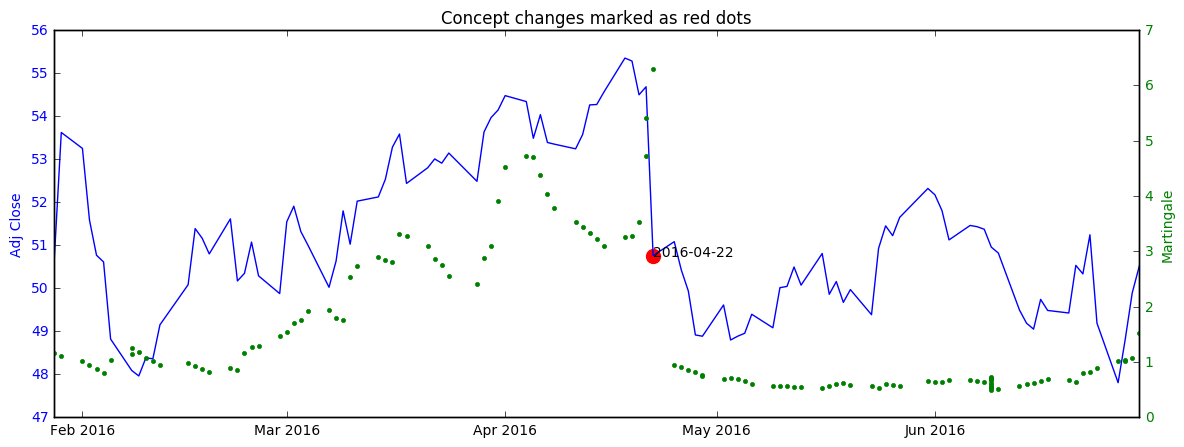

In [10]:
concept_change_dates = plot_results(X, D, results, threshold)

#### Stock data on and up to 7 days before the concept change date

In [11]:
show_data(concept_change_dates[0])

,Adj Close,Diluted EPS,Gross Margin,Operating Income,Revenue,SP500,DFF,DGS10,NASDAQ100,Acquisition,Investment
2016-04-15,54.552626,0.47,12809.0,5283.0,20531.0,2080.73,0.37,1.76,4543.16,0.0,0.0
2016-04-18,55.346651,0.47,12809.0,5283.0,20531.0,2094.34,0.37,1.78,4569.31,0.0,0.0
2016-04-19,55.278031,0.47,12809.0,5283.0,20531.0,2100.80,0.37,1.79,4537.09,0.0,0.0
2016-04-20,54.493807,0.47,12809.0,5283.0,20531.0,2102.40,0.37,1.85,4540.44,0.0,0.0
2016-04-21,54.680059,0.47,12809.0,5283.0,20531.0,2091.48,0.37,1.88,4540.80,0.0,0.0
2016-04-21,54.680059,0.47,12809.0,5283.0,20531.0,2091.48,0.37,1.88,4540.80,0.0,0.0
2016-04-22,50.758936,0.47,12809.0,5283.0,20531.0,2091.58,0.37,1.89,4474.19,0.0,0.0


Based on the martingale anomaly detection model, a concept change is detected on April 22 2016. At this point, the martingale value is higher than a predefined threshold (6.0). The date when anomaly is reported is consistent with the date when a significant close price drop occurs on April 22 2016. There is no significant delay on this detection.

In [12]:
days_to_analyse = 120
n_neighbors = 5 
threshold = 6.0
epsilon = 0.92

concept_change_dates_list=[]

for i in range (10):
    results = []

    detector = KNNAnomalyDetector(
        n_neighbors = n_neighbors, 
        epsilon = epsilon,
        threshold = threshold
    )

    msft = msft_data.as_matrix()
    X = msft[-days_to_analyse:]
    D = msft_data.index.date[-days_to_analyse:]

    for x in X:
        results.append(detector.observe(x))
    
    results = np.array(results)
    
    for d in D[results[:, 3] == 1.0]:
        concept_change_dates_list.append(d)

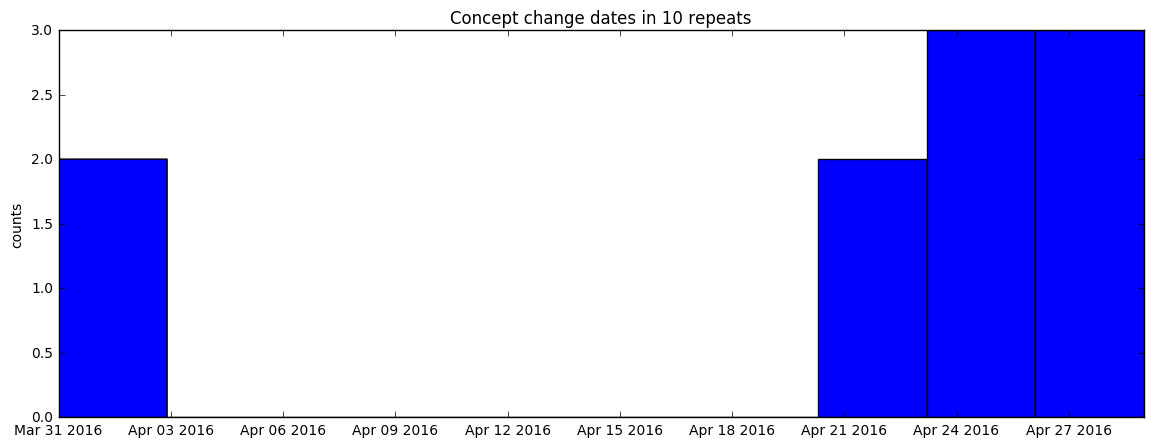

In [13]:
fig = plt.figure(figsize=(14, 5)) 
ax = fig.add_subplot(1, 1, 1)
h = ax.hist(concept_change_dates_list)
ax.set_xlabel('')
ax.set_ylabel('counts')
ax.set_title('Concept change dates in 10 repeats')

If the martingale analysis was performed multiple times, a slightly different concept change date would be reported (charts for each repeats not shown). In a 10-time-repeat experiment, the resulting concept change dates range from April 1 to April 29, with the highest frequency in April 22. 

The uncertain part in martingale-base anomaly detection is $\theta$, which is randomly chosen from $[0, 1]$ when calculating p. A smaller $\theta$ will result in a lower p value and a higher martingale value. Anomaly status of data points that has a martingale value around the threshold can easily be affected by the value of $\theta$.

#### News and SEC filings on and up to 7 days before the concept change date

In [14]:
show_news(concept_change_dates[0])

,Headline
Date,
2016-04-21 21:50:00,"CORRECTED TRANSCRIPT: Microsoft Corp.(MSFT-US), Q3 2016 Earnings Call, 21-April-2016 5:30 PM ET"
2016-04-21 18:04:00,Microsoft provides Q4 (Jun) guidance -- conf. call
2016-04-21 17:25:00,MICROSOFT CORP Investor Slides: Q3 2016 Earnings
2016-04-21 17:24:00,Fitch Affirms Microsoft Corporation at 'AA+/F1+'; Outlook Stable
2016-04-21 16:23:00,Follow-up: StreetAccount Metrics Recap - Microsoft Q3 Earnings
2016-04-21 16:17:00,StreetAccount Metrics Recap - Microsoft Q3 Earnings
2016-04-21 16:15:00,Twitter - @MSFTnews: Commercial cloud annualized revenue run rate exceeds $10.0 billion; Windows 10 active on over 270M devices https://t.co/fJqU0eRpZm
2016-04-21 16:13:00,"MICROSOFT CORP files (10-Q) Basic quarterly filing, for period end 31-Mar-16 (MSFT-US)"
2016-04-21 16:13:00,Microsoft Corp: 10-Q FactSet Blackline Report for period ending 03/31/2016


In [15]:
show_documents(concept_change_dates[0])

,Filing,Description
Date,,
2016-04-21,10-Q,Quarterly Report
2016-04-21,8-K,Current Report


After reviewing the news and SEC filings on or up to 7 days before the concept change date, we found that on April 21 2016, Microsoft announced the Third Quarter Results, which included a 6% decline in fiscal third-quarter revenue to 20.5 billion and  earnings of 3.8 billion which fell 25% year over year. This event is likely to be the causal factor inducing the stock price drop on April 22 2016.

There are two parameters in our model, $\epsilon$ and n_neighbors, can affect whether a data point would be classified as anomaly or not. In the above analysis, n_neighbors $= 5$ and $\epsilon = 0.92$ were used as default parameter values. Next, different parameter values are tried on Microsoft data.

##### Anomaly detection with a incresed $\epsilon = 0.96$

In [9]:
days_to_analyse = 120
n_neighbors = 5 
threshold = 6.0
epsilon = 0.96

results = []

detector = KNNAnomalyDetector(
    n_neighbors = n_neighbors, 
    epsilon = epsilon,
    threshold = threshold
)

msft = msft_data.as_matrix()
X = msft[-days_to_analyse:]
D = msft_data.index[-days_to_analyse:]

for x in X:
    results.append(detector.observe(x))
    
results = np.array(results)

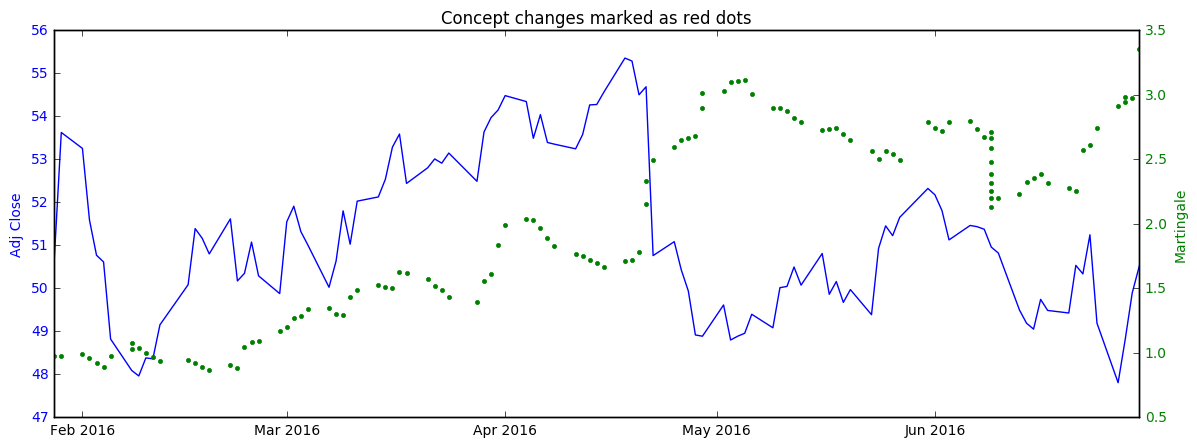

In [10]:
concept_change_dates = plot_results(X, D, results, threshold)

##### Anomaly detection with a decreased $\epsilon = 0.88$

In [11]:
days_to_analyse = 120
n_neighbors = 5 
threshold = 6.0
epsilon = 0.88

results = []

detector = KNNAnomalyDetector(
    n_neighbors = n_neighbors, 
    epsilon = epsilon,
    threshold = threshold
)

msft = msft_data.as_matrix()
X = msft[-days_to_analyse:]
D = msft_data.index[-days_to_analyse:]

for x in X:
    results.append(detector.observe(x))
    
results = np.array(results)

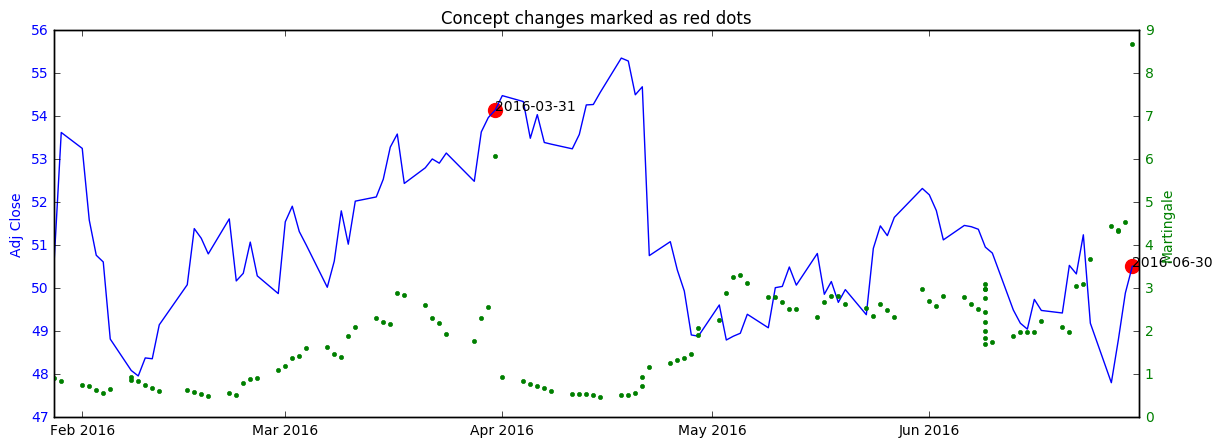

In [12]:
concept_change_dates = plot_results(X, D, results, threshold)

##### Anomaly detection with a increased n_neighbors $= 8$

In [20]:
days_to_analyse = 120
n_neighbors = 8 
threshold = 6.0
epsilon = 0.92

results = []

detector = KNNAnomalyDetector(
    n_neighbors = n_neighbors, 
    epsilon = epsilon,
    threshold = threshold
)

msft = msft_data.as_matrix()
X = msft[-days_to_analyse:]
D = msft_data.index[-days_to_analyse:]

for x in X:
    results.append(detector.observe(x))
    
results = np.array(results)

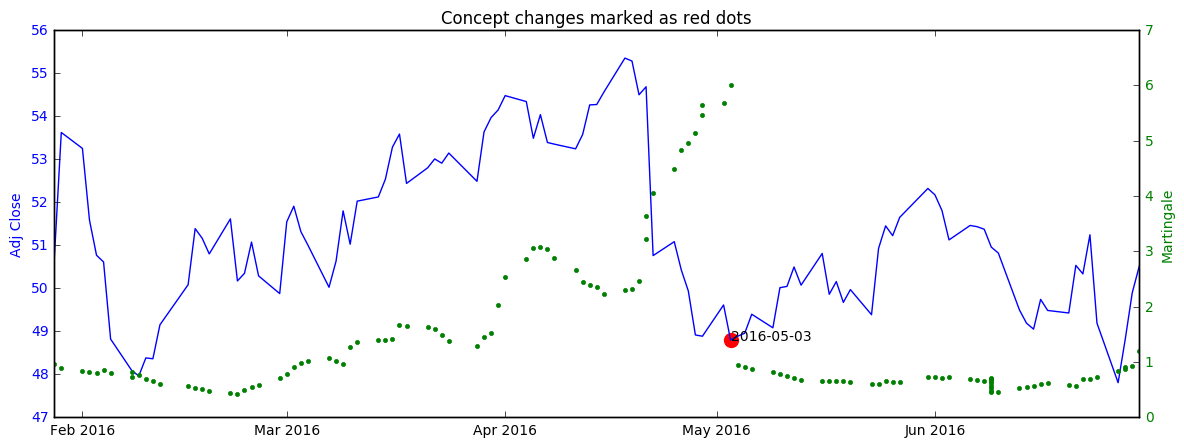

In [21]:
concept_change_dates = plot_results(X, D, results, threshold)

##### Anomaly detection with a decreased n_neighbors $= 3$

In [22]:
days_to_analyse = 120
n_neighbors = 3 
threshold = 6.0
epsilon = 0.92

results = []

detector = KNNAnomalyDetector(
    n_neighbors = n_neighbors, 
    epsilon = epsilon,
    threshold = threshold
)

msft = msft_data.as_matrix()
X = msft[-days_to_analyse:]
D = msft_data.index[-days_to_analyse:]

for x in X:
    results.append(detector.observe(x))
    
results = np.array(results)

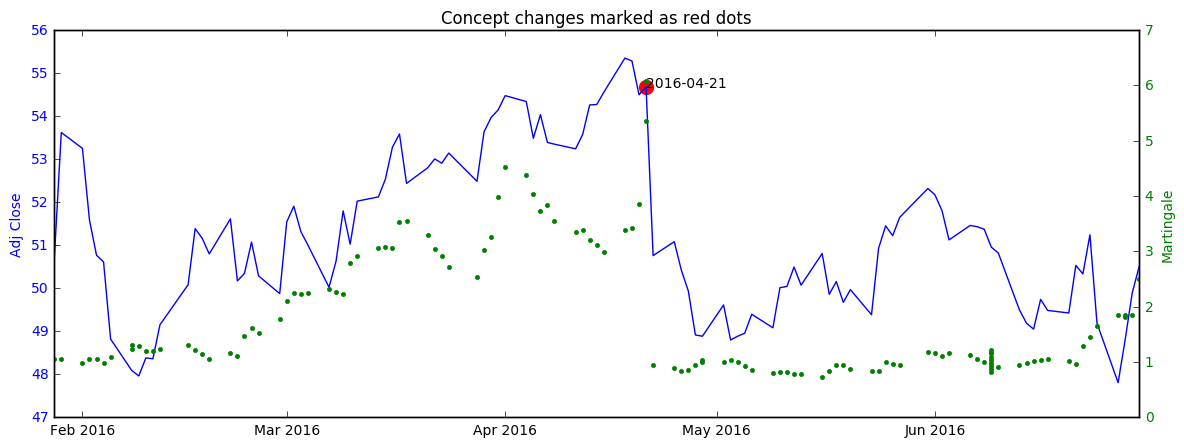

In [23]:
concept_change_dates = plot_results(X, D, results, threshold)

Alteration on both epsilon and n_neighbors can have some influence on martingale values, and then affect the decision on anomaly detection. In practical applications, the values of these two parameters need to be chosen carefully. In our analysis on Microsoft stock data, the default value of n_neighbors $= 5$ and $\epsilon = 0.92$ seems to be reasonable while further analysis need to be done in order to determine a ideal parameter for our model.

### Analysing last 360 days of MSFT stock

In [24]:
days_to_analyse = 360
n_neighbors = 5 
threshold = 6.0
epsilon = 0.92

results = []

detector = KNNAnomalyDetector(
    n_neighbors = n_neighbors, 
    epsilon = epsilon,
    threshold = threshold
)

msft = msft_data.as_matrix()
X = msft[-days_to_analyse:]
D = msft_data.index[-days_to_analyse:]

for x in X:
    results.append(detector.observe(x))
    
results = np.array(results)

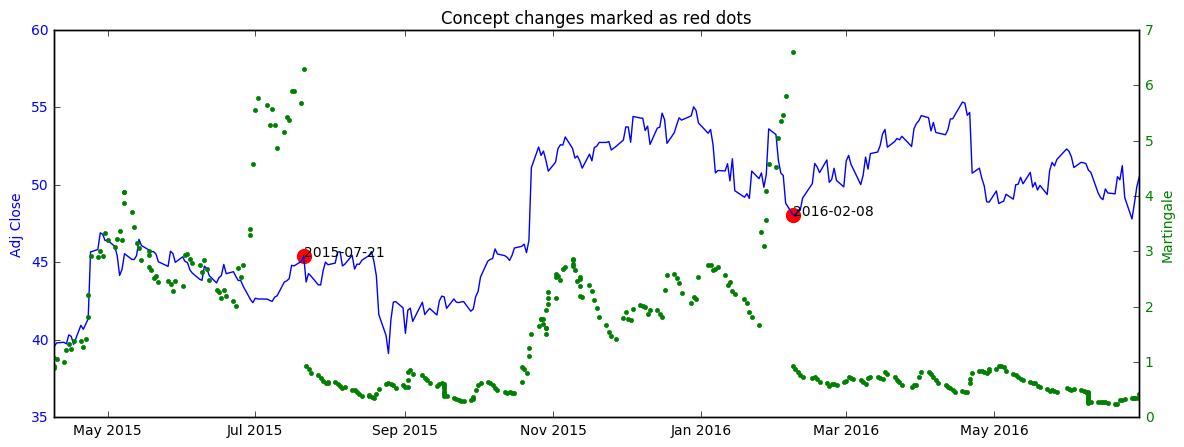

In [25]:
concept_change_dates = plot_results(X, D, results, threshold)

When running our algorithm on 360 days of Microsoft stock closing price data, two concept change dates were detected, 7/21/2015 and 2/8/2016.

#### Concept change date No.1 on July 21 2015
#### Stock data on and up to 7 days before the concept change date

In [26]:
show_data(concept_change_dates[0])

,Adj Close,Diluted EPS,Gross Margin,Operating Income,Revenue,SP500,DFF,DGS10,NASDAQ100,Acquisition,Investment
2015-07-14,43.815399,-0.4,14712.0,-2053.0,22180.0,2108.95,0.13,2.41,4523.47,0.0,0.0
2015-07-15,43.949860,-0.4,14712.0,-2053.0,22180.0,2107.40,0.13,2.36,4528.36,0.0,0.0
2015-07-16,44.814260,-0.4,14712.0,-2053.0,22180.0,2124.29,0.14,2.36,4594.90,1.0,0.0
2015-07-17,44.775841,-0.4,14712.0,-2053.0,22180.0,2126.64,0.13,2.34,4661.60,0.0,0.0
2015-07-20,45.063974,-0.4,14712.0,-2053.0,22180.0,2128.28,0.14,2.38,4679.68,0.0,0.0
2015-07-21,45.409734,-0.4,14712.0,-2053.0,22180.0,2119.21,0.13,2.35,4674.41,0.0,0.0


#### News and SEC filings on and up to 7 days before the concept change date

In [27]:
show_news(concept_change_dates[0])

,Headline
Date,
2015-07-20 13:44:00,StreetAccount Consensus Metrics Preview - Microsoft Q4 Earnings
2015-07-20 09:00:00,GE chooses Microsoft Office 365 for employee collaboration and productivity
2015-07-19 21:59:00,Microsoft to acquire Adallom - Globes
2015-07-17 12:05:00,Street Takeaways - NPD releases June US retail video game data
2015-07-16 16:06:00,Twitter - @MSFTnews: Video series: Get results with @BingAds http://t.co/zTU3DktlV9 http://t.co/YzwlIpQH1Q
2015-07-16 09:11:00,Microsoft purchases FieldOne -- Microsoft Blog
2015-07-15 14:51:00,Rand Group Achieves Microsoft's Elite Inner Circle
2015-07-15 08:05:00,AVI-SPL intervient sur scène lors de la WPC 2015 de Microsoft afin d'évoquer l'adoption du Surface Hub


In [28]:
show_documents(concept_change_dates[0])

,Filing,Description
Date,,
2015-07-21,8-K,Current Report


#### Concept change date No.2 on February 8 2016
#### Stock data on and up to 7 days before the concept change date

In [29]:
show_data(concept_change_dates[1])

,Adj Close,Diluted EPS,Gross Margin,Operating Income,Revenue,SP500,DFF,DGS10,NASDAQ100,Acquisition,Investment
2016-02-01,53.248840,0.62,13924.0,6026.0,23796.0,1939.38,0.38,1.97,4286.56,0.0,0.0
2016-02-02,51.584510,0.62,13924.0,6026.0,23796.0,1903.03,0.38,1.87,4193.10,0.0,0.0
2016-02-03,50.766944,0.62,13924.0,6026.0,23796.0,1912.53,0.38,1.88,4171.97,1.0,0.0
2016-02-04,50.611218,0.62,13924.0,6026.0,23796.0,1915.45,0.38,1.87,4167.77,0.0,0.0
2016-02-05,48.820359,0.62,13924.0,6026.0,23796.0,1880.05,0.38,1.86,4024.47,0.0,0.0
2016-02-08,48.090390,0.62,13924.0,6026.0,23796.0,1853.44,0.38,1.75,3960.67,0.0,0.0
2016-02-08,48.090390,0.62,13924.0,6026.0,23796.0,1853.44,0.38,1.75,3960.67,0.0,0.0


#### News and SEC filings on and up to 7 days before the concept change date

In [30]:
show_news(concept_change_dates[1])

,Headline
Date,
2016-02-05 16:34:00,"Dir GATES III Sells 2,000,000 of MICROSOFT CORP (MSFT)"
2016-02-05 08:00:00,E-School for Girls partners with NYU and Microsoft for entrepreneurship event
2016-02-04 16:42:00,"Dir GATES III Sells 2,000,000 of MICROSOFT CORP (MSFT)"
2016-02-04 13:57:00,StreetAccount Event Preview - Tableau Software 4Q Earnings
2016-02-04 09:36:00,Microsoft Corp agreed to acquire TouchType Ltd
2016-02-03 20:25:00,Twitter - @MSFTnews: Microsoft announces general availability for #Azure #IoT Hub https://t.co/FRy4NsMmh9 https://t.co/pUjxDgxnNK
2016-02-03 16:48:00,"Dir GATES III Sells 1,000,000 of MICROSOFT CORP (MSFT)"
2016-02-03 13:36:00,Microsoft Corporation (Nasdaq: MSFT) and We Connect the Dots to Ring The Nasdaq Stock Market Opening Bell
2016-02-03 13:13:00,"Twitter - @MSFTnews: Show, don't tell: Publish eye-catching Power BI data reports straight to Web https://t.co/R8mHgyaWSD https://t.co/W5cvZrHNZj"


In [31]:
show_documents(concept_change_dates[1])

,Filing,Description
Date,,
2016-02-08,424B2,Prospectus Filed Pursuant to Rule 424
2016-02-08,FWP,Free Writing Prospectus - Filing under Securities Act Rules 163/433
2016-02-05,4,Statement of Changes of Beneficial Ownership
2016-02-02,4,Statement of Changes of Beneficial Ownership
